# Create a submission for the ANDI challenge 2

This notebook shows the pipeline to create a submission of the [AnDi 2 challenge](https://andi-challenge.org/challenge-2024/) with our methods.

Let's download the data from the [2nd AnDi Challenge](https://codalab.lisn.upsaclay.fr/competitions/16618).

In [95]:
#| export

from pathlib import Path
from zipfile import ZipFile
from urllib.request import urlretrieve

import re, shutil, numpy as np, pandas as pd
from tqdm.auto import tqdm, trange
from fastai.vision.all import *
from torch.utils.data import Dataset#, DataLoader

In [96]:
#| export

def get_challenge_data(url, data_path):
    """Download the available public data from the url and save it in the desired path."""
    data_path = Path(data_path)
    data_path.mkdir(exist_ok=True)
    temp = (data_path.parent/"temp").with_suffix(".zip")
    urlretrieve(url, temp)
    # TODO download progress bar
    with ZipFile(temp, "r") as zipped_file:
        zipped_file.extractall(data_path)
    temp.unlink()

In [97]:
# where to download
data_path = Path("../../data/raw/")
if not data_path.exists():    os.makedirs(data_path)

In [ ]:
# url_starting_kit = "https://codalab.lisn.upsaclay.fr/my/datasets/download/338ee871-3adf-401b-add8-abe82579c58b"

In [ ]:
# get_challenge_data(url_starting_kit, data_path/"starting_kit")

In [16]:
url_challenge = "https://codalab.lisn.upsaclay.fr/my/datasets/download/1086ae21-a81b-47cd-9899-089d2527bfc1"

In [17]:
get_challenge_data(url_challenge, data_path/"challenge")

In [98]:
public_data_path = data_path/"challenge"

In our case, we will gather our submission files in the following root path:

In [99]:
import os
path_submit = '../../data/submit/20240714/'
path_results = path_submit + 'res/'
path_scores  = path_submit + 'score/'
if not os.path.exists(path_results):   os.makedirs(path_results)
if not os.path.exists(path_scores):    os.makedirs(path_scores)

In [100]:
dvc = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'); dvc

device(type='cuda')

# Track 1: videos

In [101]:
path_intermediate_results = path_submit + 'proc/'
if not os.path.exists(path_intermediate_results):   os.makedirs(path_intermediate_results)

In [102]:
from tqdm.auto import trange, tqdm

## Detection with LodeSTAR

In [103]:
def get_video_from_path(path):
    try:
        reader = imageio.get_reader(path)
    except Exception as e:
        print("Error opening video file: ", e)
        return None
    frames = [np.array(im) for im in reader]
    return np.stack(frames[1:])

In [104]:
import deeplay as dp, imageio

In [105]:
# load model
# instantiate model with GPU if available
with torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'):
    lodestar = dp.LodeSTAR(optimizer=dp.Adam(lr=1e-4),).build()

# load weights
lodestar.load_state_dict(torch.load("../../models/lodestar_centered_crops.pth",map_location=dvc))

<All keys matched successfully>

In [106]:
lodestar.device

device(type='cuda', index=0)

In [107]:
# Define the number of experiments and number of FOVS
N_EXP  = 12  # 13 
N_FOVS = 30

track = 1

# The intermediate results (detections) go in the folders generated above
path_track = path_intermediate_results + f'track_{track}/'

In [108]:
for exp in trange(N_EXP):
    path_exp = Path(path_track + f'exp_{exp}/')
    # the folder has to exist for writing the results file therein
    if not os.path.exists(path_exp):    os.makedirs(path_exp)
    for fov in trange(N_FOVS):
        # We read the corresponding tiff file
        video_path = public_data_path/f'track_{track}/exp_{exp}/videos_fov_{fov}.tiff'
        video = get_video_from_path(video_path)
        # preprocess the video
        video = torch.from_numpy(video).float().unsqueeze(1) / 256
        # detect all particles 
        # (big)low alpha for very (un)similar shapes
        alpha = 0.01  ;  beta = 1-alpha  ;  cutoff = 0.2
        with torch.inference_mode():
            lodestar_preds = lodestar.detect(video, alpha=alpha, beta=beta, # T',N',2
                                             mode="constant", cutoff=cutoff)
        # TODO assert preds are positive
        # save
        np.save(path_exp/f'detections_fov_{fov}', np.array(lodestar_preds, dtype=object), allow_pickle=True)
    print(f"Saved at {path_exp/f'detections_fov_{fov}.npy'}")

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_0/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_1/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_2/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_3/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_4/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_5/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_6/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_7/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_8/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_9/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_10/detections_fov_29.npy


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/proc/track_1/exp_11/detections_fov_29.npy


In [109]:
!ls ../../data/submit/20240714/proc/track_1/exp_3

detections_fov_0.npy   detections_fov_28.npy  trajs_fov_19.npy
detections_fov_10.npy  detections_fov_29.npy  trajs_fov_1.npy
detections_fov_11.npy  detections_fov_2.npy   trajs_fov_20.npy
detections_fov_12.npy  detections_fov_3.npy   trajs_fov_21.npy
detections_fov_13.npy  detections_fov_4.npy   trajs_fov_22.npy
detections_fov_14.npy  detections_fov_5.npy   trajs_fov_23.npy
detections_fov_15.npy  detections_fov_6.npy   trajs_fov_24.npy
detections_fov_16.npy  detections_fov_7.npy   trajs_fov_25.npy
detections_fov_17.npy  detections_fov_8.npy   trajs_fov_26.npy
detections_fov_18.npy  detections_fov_9.npy   trajs_fov_27.npy
detections_fov_19.npy  trajs_fov_0.npy	      trajs_fov_28.npy
detections_fov_1.npy   trajs_fov_10.npy       trajs_fov_29.npy
detections_fov_20.npy  trajs_fov_11.npy       trajs_fov_2.npy
detections_fov_21.npy  trajs_fov_12.npy       trajs_fov_3.npy
detections_fov_22.npy  trajs_fov_13.npy       trajs_fov_4.npy
detections_fov_23.npy  trajs_fov_14.npy       trajs_fov_5.np

In [110]:
# check results
detections = np.load(path_exp/f'detections_fov_{0}.npy', allow_pickle=True)

In [111]:
detections

array([array([[-54.06305  , -10.5528965],
              [-49.25722  ,   5.457162 ],
              [-42.503616 ,  40.52872  ],
              [-34.84296  , -35.884747 ],
              [-25.991772 ,   1.9479926],
              [-22.742981 ,   8.332703 ],
              [-12.795335 , -30.685183 ],
              [ -8.16286  , -23.143875 ],
              [  7.858407 , -33.852547 ],
              [  9.925802 ,  11.168505 ],
              [ 17.261917 , -20.463829 ],
              [ 17.227169 , -34.02101  ],
              [ 16.71115  ,  33.45868  ],
              [ 20.60167  , -24.529634 ],
              [ 27.15872  ,  41.777554 ],
              [ 38.10318  , -38.288597 ],
              [ 39.477154 , -24.345814 ],
              [ 38.878677 , -29.251598 ],
              [ 42.402145 ,  27.116432 ],
              [ 53.984787 , -27.431719 ],
              [ 50.13607  ,  42.82619  ],
              [ 57.037457 ,  17.82928  ]], dtype=float32),
       array([[-55.14948   , -10.130582  ],
              [

## Link with MAGIK

In [112]:
import torch
from torch_geometric.data import Data


class GraphFromDetections:
    def __init__(self, connectivity_radius, max_frame_distance):
        self.connectivity_radius = connectivity_radius
        self.max_frame_distance  = max_frame_distance

    def __call__(self, frames, # T, (N', F or 2)
                 data_norm,    # to normalize positions
                 relation=None):
        x, node_index_labels, frames_t = [], [], []
        for frame_t, frame in enumerate(frames):  # N', 7:traj_idx 	frame 	x 	y 	alpha 	D 	state
            features =  frame[:,:2]/data_norm
            frames_t.append([frame_t]*len(features))
            x.append(features)

        frames_t          = np.concatenate(frames_t)         # T*N'
        x                 = np.concatenate(x)                # T*N',F

        N_ = np.cumsum([f.shape[0] for f in frames])
        edge_index, edge_attr = self.get_edges_and_distances_in_frames(
            x[:, :2], N_, self.connectivity_radius,self.max_frame_distance)

        edge_attr = edge_attr[:, None]  # distance # TODO augment to be (dr,dtheta) for alpha, D, and state prediction

        graph = Data(                                       # (10)
            x          = torch.tensor(x,          dtype=torch.float),
            edge_index = torch.tensor(edge_index, dtype=torch.long),
            edge_attr  = torch.tensor(edge_attr,  dtype=torch.float),
            distance   = torch.tensor(edge_attr,  dtype=torch.float),
            frames_t   = torch.tensor(frames_t,   dtype=torch.float),  # TODO float or int?
        )

        return graph

    def compute_connectivity(self, x, # T*N',F;
                             frames): # T*N'
        positions = x[:, :2] # T*N',2;
        distances = np.linalg.norm(positions[:, None] # T*N',1,2;
                                   - positions,       # T*N',2;
                                   axis=-1)           # T*N',T*N';

        frame_diff = (frames[:, None]  # T*N',1
                      - frames         # T*N'
                     ) * -1            # T*N', T*N'

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr        

    def get_edges_and_distances_in_frames(self, positions, # T*N',2
                            N_,        # =N'_t; T
                            connectivity_radius,
                            max_frame_distance:int=1 # minimum 1, the next timestep
                           ):
        """Broadcasts to allowed forthcoming frames"""
        # ideal-code:
        # positions[     :N'_0,  None] - positions[N'_0:N'_(0+max_frame_distance)]  # N'_0, N'_1+...N'_(0+max_frame_distance),2
        # positions[N'_0 :N'_1,  None] - positions[N'_1:N'_(1+max_frame_distance)]  # N'_1, N'_2+...  , 2
        # positions[N'_1 :N'_2,  None] - positions[N'_2:N'_(2+max_frame_distance)]
        # ... (T-max_frame_distance times)
        # positions[N'_i :N'_i+1,  None] - positions[N'_i+1:N'_((T-max_frame_distance)+max_frame_distance)]
        #
        # positions[N'_T-5:N'_T-4, None] - positions[N'_T-4:N'_(T-1)]
        # positions[N'_T-4:N'_T-3, None] - positions[N'_T-3:N'_T-1]
        # positions[N'_T-3:N'_T-2, None] - positions[N'_T-2:N'_T-1]
        # up to T-1 = T-1 -(T-max_frame_distance) = max_frame_distance - 1
        # positions[N'_i  :N'_i+1, None] - positions[N'_i+1:]
        T = len(N_)
        N_ = np.concatenate((np.array([0]), N_))  # T+1
        distances = []
        edges_idx = []
        for i in range(T-max_frame_distance):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:N_[i+(max_frame_distance+1)]],
                               axis=-1)                  # N_[i+1], N[i+2]+...
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            distances.append(d[idx])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
    
        for i in range(T-max_frame_distance, T-1):
            d = np.linalg.norm(positions[N_[i]  :N_[i+1],  None]
                             - positions[N_[i+1]:],
                               axis=-1)                  # N_[i+1], N[i+2]+...N[-1]
            idx = np.nonzero(d < connectivity_radius)    # tuple: 2, near
            distances.append(d[idx])
            edges_idx.append(np.array(idx) + np.array([N_[i:i+1], N_[i+1:i+2]]))
    
        distances = np.concatenate(distances)            # T*near'
        edges_idx = np.concatenate(edges_idx, axis=-1)   # 2, T*near'
        return edges_idx, distances

In [113]:
graph_constructor = GraphFromDetections(connectivity_radius=0.05, max_frame_distance=2)

In [114]:
import networkx as nx

class compute_trajectories:
    def __call__(self, graph, predictions):
        pruned_edges = self.prune_edges(graph, predictions)

        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)

        trajectories = list(nx.connected_components(pruned_graph))

        return trajectories

    def prune_edges(self, graph, predictions):
        pruned_edges = []

        frame_pairs = np.stack(
            [graph.frames_t[graph.edge_index[0]], graph.frames_t[graph.edge_index[1]]],
            axis=1,
        )

        senders = np.unique(graph.edge_index[0])
        for sender in senders: 
            sender_mask = graph.edge_index[0] == sender # (1)
            candidate = predictions[sender_mask] == True # (2)

            frame_diff = frame_pairs[sender_mask, 1] - frame_pairs[sender_mask, 0]
            candidates_frame_diff = frame_diff[candidate]

            if not np.any(candidate):
                continue
            else:
                candidate_min_frame_diff = candidates_frame_diff.min()
            
            candidate_edge_index = graph.edge_index[:, sender_mask][ # (3)
                :, candidate & (frame_diff == candidate_min_frame_diff)
            ]
            candidate_edge_index = candidate_edge_index.reshape(-1, 2)

            if len(candidate_edge_index) == 1: # (4)
                pruned_edges.append(tuple(*candidate_edge_index.numpy()))

        return pruned_edges

post_processor = compute_trajectories()

In [115]:
from tqdm.auto import trange
import os, numpy as np
from pathlib import Path

In [116]:
from deeplay import GraphToEdgeMAGIK
import torch.nn as nn
# load model
# instantiate model with GPU if available
with torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'):
    model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid) # (1)

model.encoder[0].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (2)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (3)
model.head.configure(hidden_features=[64, 32])

next(model.parameters()).device

device(type='cuda', index=0)

In [117]:
from deeplay import BinaryClassifier, Adam, Trainer

classifier = BinaryClassifier(model=model, optimizer=Adam(lr=1e-3))
classifier = classifier.build()
if torch.cuda.is_available(): classifier.cuda()
# load weights
classifier.load_state_dict(torch.load("../../models/MAGIK_20240714.pth", map_location=dvc),)

<All keys matched successfully>

In [118]:
next(model.parameters()).device

device(type='cuda', index=0)

In [119]:
# Define the number of experiments and number of FOVS
N_EXP  = 12  # 13 
N_FOVS = 30

track = 1

# The intermediate results (detections) go in the folders generated above
path_track = path_intermediate_results + f'track_{track}/'

classifier.eval()

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): GraphToEdgeMAGIK(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=32, bias=True)
            (activation): ReLU()
          )
          (1): LinearBlock(
            (layer): Linear(in_features=32, out_features=64, bias=True)
            (activation): ReLU()
          )
          (2): LinearBlock(
            (layer): Linear(in_features=64, out_features=96, bias=True)
            (activation): ReLU()
          )
        )
      )
    )
    (backbone): MessagePassingNeuralNetwork(
      (blocks): LayerList(
        (0): Learn

In [120]:
classifier.device

device(type='cuda', index=0)

In [121]:
!ls ../../data/submit/20240714/proc/track_1/  #exp_0/  #detections_fov_0.npy'

exp_0  exp_10  exp_2  exp_4  exp_6  exp_8
exp_1  exp_11  exp_3  exp_5  exp_7  exp_9


In [87]:
for exp in trange(N_EXP):
    path_exp = Path(path_track + f'exp_{exp}/')
    # the folder has to exist for writing the results file therein
    if not os.path.exists(path_exp):    os.makedirs(path_exp)
    for fov in trange(N_FOVS):
        # load detections (of all detected particles)
        # We read the corresponding npy file
        detections_path = path_exp/f'detections_fov_{fov}.npy'
        detections = np.load(detections_path, allow_pickle=True)
        # create graph
        graph = graph_constructor(detections, 128)
        if torch.cuda.is_available(): graph.cuda()
        # MAGIK link prediction
        pred = classifier(graph) # needs attribute distance!!!
        if torch.cuda.is_available(): pred=pred.cpu(); graph.cpu()
        predictions = pred.detach().numpy() > 0.5
        # post-process
        trajs_idx_cat = post_processor(graph, predictions.squeeze())
        trajs = []
        for traj_idx_cat in trajs_idx_cat:
            t = sorted (traj_idx_cat) # list
            trajs.append(np.concatenate((
                                 graph.frames_t[t].numpy()[:,None],
                                 graph.x[t].numpy()*128),  # T',2
                                axis=-1))
        # save all trajectories with traj_idx (Later select VIPs?)
        np.save(path_exp/f'trajs_fov_{fov}', np.array(trajs, dtype=object), allow_pickle=True)
    print(f"Saved at {path_exp/f'trajs_fov_{fov}.npy'}")

  8%|███▋                                        | 1/12 [00:43<08:03, 43.94s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_0/trajs_fov_29.npy



 17%|███████▎                                    | 2/12 [01:21<06:40, 40.01s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_1/trajs_fov_29.npy



 25%|███████████                                 | 3/12 [02:08<06:28, 43.12s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_2/trajs_fov_29.npy



 33%|██████████████▋                             | 4/12 [02:45<05:26, 40.82s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_3/trajs_fov_29.npy



 42%|█████████████████▉                         | 5/12 [06:12<11:44, 100.71s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_4/trajs_fov_29.npy



 50%|██████████████████████                      | 6/12 [06:46<07:48, 78.08s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_5/trajs_fov_29.npy



 58%|█████████████████████████▋                  | 7/12 [07:25<05:26, 65.31s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_6/trajs_fov_29.npy



 67%|████████████████████████████▋              | 8/12 [11:35<08:16, 124.05s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_7/trajs_fov_29.npy



 75%|█████████████████████████████████           | 9/12 [12:11<04:49, 96.49s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_8/trajs_fov_29.npy



 83%|███████████████████████████████████▊       | 10/12 [12:43<02:33, 76.71s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_9/trajs_fov_29.npy



 92%|███████████████████████████████████████▍   | 11/12 [13:00<00:58, 58.29s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_10/trajs_fov_29.npy



100%|███████████████████████████████████████████| 12/12 [13:27<00:00, 67.31s/it]

Saved at ../../data/submit/20240714/proc/track_1/exp_11/trajs_fov_29.npy


In [88]:
trajs

[array([[  0.      , -56.003002,  27.18576 ],
        [  1.      , -56.102   ,  27.24371 ]], dtype=float32),
 array([[  0.      , -53.409866, -59.10833 ],
        [  1.      , -53.61607 , -58.580883],
        [  2.      , -54.29936 , -56.464012],
        [  3.      , -55.491577, -54.902897],
        [  4.      , -54.93214 , -52.206287],
        [  5.      , -55.154137, -50.65522 ],
        [  6.      , -56.19819 , -49.33873 ],
        [  7.      , -57.456493, -48.58717 ],
        [  8.      , -57.703445, -47.147034],
        [  9.      , -57.795013, -46.8106  ],
        [ 10.      , -57.918446, -46.97812 ],
        [ 11.      , -58.482006, -46.727196],
        [ 12.      , -58.604565, -46.886642],
        [ 13.      , -59.35344 , -47.00676 ]], dtype=float32),
 array([[  0.      , -34.72993 , -50.73961 ],
        [  1.      , -32.794807, -50.226803],
        [  2.      , -32.03203 , -50.108658],
        [  3.      , -31.0993  , -50.634712],
        [  4.      , -29.501223, -51.211132],


In [89]:
# check results
trajs_ = np.load(path_exp/f'trajs_fov_{fov}.npy', allow_pickle=True)

In [90]:
trajs_

array([array([[  0.      , -56.003002,  27.18576 ],
              [  1.      , -56.102   ,  27.24371 ]], dtype=float32),
       array([[  0.      , -53.409866, -59.10833 ],
              [  1.      , -53.61607 , -58.580883],
              [  2.      , -54.29936 , -56.464012],
              [  3.      , -55.491577, -54.902897],
              [  4.      , -54.93214 , -52.206287],
              [  5.      , -55.154137, -50.65522 ],
              [  6.      , -56.19819 , -49.33873 ],
              [  7.      , -57.456493, -48.58717 ],
              [  8.      , -57.703445, -47.147034],
              [  9.      , -57.795013, -46.8106  ],
              [ 10.      , -57.918446, -46.97812 ],
              [ 11.      , -58.482006, -46.727196],
              [ 12.      , -58.604565, -46.886642],
              [ 13.      , -59.35344 , -47.00676 ]], dtype=float32),
       array([[  0.      , -34.72993 , -50.73961 ],
              [  1.      , -32.794807, -50.226803],
              [  2.      , -32

TODO ensemble characterization with MAGIK from detections.

## Characterization with STEPs

This is done in the next part, after track2 single trajectory characterization.

TODO ensemble of track 1 with k-means from STEP predictions.

# Track 2: trajectories

## Single trajectory task

### Load STEP models, preprocessing, and ruptures

In [1]:
from step.data import *
from step.utils import *
from step.models import *

from tqdm.auto import tqdm, trange
from fastai.vision.all import *

dim = 2

In [2]:
from tqdm.contrib import tenumerate, tzip, tmap as tqmap

In [3]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

In [6]:
# STEPalpha: Anomalous exponent model
with default_device():
    model_alpha = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, n_encoder_layers=4,
                 dim_ff=512, nhead_enc=8, norm=False, linear_layers=[],yrange=(-0.1,2.1))
    # Create the learner
    learn_alpha  = Learner(dls, model_alpha,  loss_func=L1LossFlat(), model_dir=MODEL_PATH)
    # load the weights
    model_alpha_path = Path('xresattn_alpha_2d_varlen_relpolar_yrange_m01_21_big22E2')
    model_alpha_name = model_alpha_path.name
    learn_alpha.load(model_alpha_path)
    learn_alpha.model.eval();

/home/gfernandez/miniforge3/envs/test2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
# STEP_log10D: Diffusion coefficient model
with default_device():
    model_log_d = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], dropout=0., pos_enc=False, 
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-6.5,2.5))# (-10.5,4.5)) # #(-10.1, 2.1))
    learn_log_d = Learner(dls, model_log_d, loss_func=MSELossFlat(), model_dir=MODEL_PATH)
    
    model_log_d_path = Path('xresattn_2d_varlen_relpolar_log10r_yrange_m65_25_big17E2')
    
    learn_log_d.load(model_log_d_path)
    model_log_d_name = model_log_d_path.name
    learn_log_d.model.eval();

In [8]:
# STEPstates: States model
with default_device():
    model_state = XResAttn(dim, n_class=4, stem_szs=(32,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], dropout=0.,
                     pos_enc=False, n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[])
# Create the learner
learn_state  = Learner(dls, model_state,  loss_func=L1LossFlat(), model_dir=MODEL_PATH)
# load the weights
learn_state.load('xresattn_states_2d_varlen')
learn_state.model.eval();

In [9]:
def get_angle(from_vec, # T, d=2
              to_vec,   # T, d=2
              ):
    x1, y1 = from_vec[...,0], from_vec[...,1]
    x2, y2 = to_vec[...,0], to_vec[...,1]
    dot = x1*x2 + y1*y2      # Dot product between [x1, y1] and [x2, y2]
    det = x1*y2 - y1*x2      # Determinant (cross2d) # 2.53 micros, njit 256 ns
    return np.arctan2(det, dot)

# We want a relative description of the trajectory
# the modulus of the displacement Delta r, and the change of angle between successive displacements Delta theta 
def cartesian_to_relative_polar(trajs_cart):
    """
    Converts 2D trajectories in cartesian coordinates to 
    a relative representation of polar coordinates.
    
    Parameters:
    - cartesian_coordinates:
    A numpy array of shape (N, T, 2) where
    N is the number of trajectories,
    T is the number of time steps, and
    2 represents the x and y coordinates.
    
    Returns:
    - An array containing:
    the radius (rho) of each point, and
    the angle from previous direction (theta) of each point in radians.
    """
    # take displacements of the trajectory
    disps_cart = trajs_cart[:, 1:] - trajs_cart[:, :-1]
    # Allocate
    polar_coords = np.zeros_like(disps_cart)
    
    # Calculate the magnitude (rho) of each point
    polar_coords[...,0] = np.hypot(disps_cart[..., 0], disps_cart[..., 1])  #  dr
    
    # Calculate the angle (theta) between segments
    v1,v2 = trajs_cart[:,1:-1]-trajs_cart[:,:-2], trajs_cart[:,2:]-trajs_cart[:,1:-1]
    polar_coords[:,1:,1] = get_angle(v1,v2) # d theta
    
    return polar_coords

In [10]:
def pred(model, x):
    with torch.no_grad():
        return to_detach(model(x))#.squeeze()

In [11]:
def create_batches(trajs, lengths, bs=2**6):
    """ Create a list of trajectories grouped in batches of the same length (Buckets).
        trajs is a fastai list L.
    """
    lengths_u, lengths_idx, lengths_counts = np.unique(lengths, return_inverse=True, return_counts=True, )
    batches = []
    for j,l in enumerate(lengths_u): # tenumerate
        indices = np.flatnonzero(lengths_idx==j)  # indices of trajs with length l
        batches_num = int(np.floor(lengths_counts[j]/bs))  # possible complete batches of batch size bs
        if batches_num==0:
            batches.append(torch.concat((*trajs[indices],)).to(default_device()))
        else:
            for i in range(batches_num):
                batches.append(torch.concat((*trajs[indices[bs*i:bs*(i+1)]],)).to(default_device()))
            if lengths_counts[j]%bs:
                batches.append(torch.concat((*trajs[indices[bs*(i+1):]],)).to(default_device()))
    return batches

def flat_batches(batched_list, lengths, bs=2**6, f=lambda x: x):
    """Flattens the list of batches with the same ordering of the initial list"""
    lengths_u, lengths_idx, lengths_counts = np.unique(lengths, return_inverse=True, return_counts=True, )
    flat = [None for i in range(len(lengths_idx))]
    batches_size = [b.shape[0] for b in batched_list]
    assert max(batches_size)<=bs
    b = 0  # batch idx
    for j,l in enumerate(lengths_u): # tenumerate
        indices = np.flatnonzero(lengths_idx==j)  # indices of trajs with length l
        batches_num = int(np.floor(lengths_counts[j]/bs))  # possible complete batches of batch size bs
        if batches_num==0:
            for k,i in enumerate(indices): flat[i] = f(batched_list[b][k])
            b+=1
        else:
            for bn in range(batches_num):
                for k,i in enumerate(indices[bs*bn:bs*(bn+1)]): flat[i] = f(batched_list[b][k])
                b+=1
            if lengths_counts[j]%bs:
                for k,i in enumerate(indices[bs*(bn+1):]): flat[i] = f(batched_list[b][k])
                b+=1
    #print('Number of batches:', b)
    return flat

In [12]:
import ruptures as rpt
# https://centre-borelli.github.io/ruptures-docs/code-reference/detection/kernelcpd-reference/#ruptures.detection.kernelcpd.KernelCPD
def find_segments(pred_d, pred_alpha, pred_state,# T
                  pen=1, # penalty, beta
                  **kwargs):
    pred = np.stack((pred_d , pred_alpha, pred_state), axis=-1) # T, 2
    alg = rpt.KernelCPD(**kwargs).fit(pred) # Shape (n_samples, n_features) or (n_samples,).
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    Ds, alphas, states = [], [], []
    for i, j in zip(cps[:-1], cps[1:]):
        alpha_seg, D_seg = pred_alpha[i:j].mean(), pred_d[i:j].mean()
        # majority vote for states
        states_u, states_u_counts = np.unique(pred_state[i:j], return_counts=True)
        states_seg = states_u[0]  if len(states_u)==1 else states_u[np.argmax(states_u_counts)]
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        states.append(states_seg)
    #residence_time = cps[1:] - cps[:-1] # segment_length

    return Ds, alphas, states, cps #,residence_time

### pipeline verification

In [13]:
import pandas as pd

In [22]:
df = pd.read_csv(public_data_path/'track_2/exp_0/trajs_fov_0.csv')
df

,traj_idx,frame,x,y
0,0.0,0.0,158.678306,62.227796
1,0.0,1.0,158.164005,62.182149
2,0.0,2.0,158.289853,62.206157
3,0.0,3.0,157.655299,62.376015
4,0.0,4.0,157.722756,61.929970
...,...,...,...,...
7091,36.0,195.0,157.007653,64.825855
7092,36.0,196.0,156.918383,64.691080
7093,36.0,197.0,156.789562,64.567802
7094,36.0,198.0,157.042212,64.113052


In [23]:
# unique ids, and lengths
traj_idx, lengths = np.unique(df['traj_idx'].values, return_counts=True)
trajs = np.array_split(df[['x','y']].values, np.cumsum(lengths)[:-1]) # assumes data is ordered by trajs_idx, alternative using mask
trajs_t = L([torch.tensor(traj, dtype=torch.float).unsqueeze(0).to(default_device()) for traj in trajs])
trajs_polar = L([torch.tensor(cartesian_to_relative_polar(traj[None]), dtype=torch.float).to(default_device()) for traj in trajs])
# disp = [traj[1:] - traj[:-1] for traj in trajs]
# std  = [dis.std(0,keepdims=True) for dis in disp]
# trajs_norm = L([torch.cat((torch.tensor(np.zeros_like(sd), dtype=torch.float),
#                           torch.tensor(dis/sd, dtype=torch.float
#                                       ).cumsum(0)), dim=0).unsqueeze(0).to(default_device())
#                 for dis, sd in zip(disp, std)])

In [24]:
trajs[0].shape, trajs[1].shape

((200, 2), (200, 2))

In [25]:
trajs_t[0].shape, trajs_t[1].shape

(torch.Size([1, 200, 2]), torch.Size([1, 200, 2]))

In [26]:
trajs_polar[0].shape

torch.Size([1, 199, 2])

In [27]:
bs = 10
trajs_batches = create_batches(trajs_t, lengths, bs=bs)
# trajs_norm_b  = create_batches(trajs_norm, lengths, bs=bs)
trajs_polars = create_batches(trajs_polar, lengths, bs=bs)
# preds_a_b     = [pred(learn_alpha.model, t)  for t in tqdm(trajs_norm_b)]
preds_a_b     = [pred(learn_alpha.model, t)  for t in tqdm(trajs_polars)]
# preds_d_b     = [pred(learn_log_d.model, t) for t in tqdm(trajs_batches)]
preds_d_b     = [pred(learn_log_d.model, torch.log10(torch.maximum(t,torch.tensor(1e-10)))) for t in tqdm(trajs_polars)]
preds_s_b     = [pred(learn_state.model, t) for t in tqdm(trajs_batches)]

preds_a = flat_batches(preds_a_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze())
preds_d = flat_batches(preds_d_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze())
preds_s = flat_batches(preds_s_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze())

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
preds_a[0].shape, preds_d[0].shape, preds_s[0].shape

((199,), (199,), (200, 4))

In [28]:
i=1

pred_d, pred_a, pred_s = preds_d[i], preds_a[i], preds_s[i]
d_seg, a_seg, s_seg, cps = find_segments(pred_d, pred_a, np.argmax(pred_s[1:],axis=-1), min_size=4, pen=5, kernel="rbf")
d_seg, a_seg, s_seg = list(map(np.array, [d_seg, a_seg, s_seg ]))
# avoid too close values in segments
keep_cps = np.logical_or(np.abs(np.diff(a_seg))>0.1 ,np.abs(np.diff(d_seg))>0.1)
print(keep_cps, cps)
a_seg = np.concatenate((a_seg[0:1], a_seg[1:][keep_cps]))
d_seg = np.concatenate((d_seg[0:1], d_seg[1:][keep_cps]))
s_seg = np.concatenate((s_seg[0:1], s_seg[1:][keep_cps]))
cps   = np.concatenate((cps[1:-1][keep_cps],cps[-1:])) if np.any(keep_cps) else cps[-1:]

# if np.any(a_seg>=1.9)
[b for a in list(zip( 10**d_seg, a_seg, s_seg, cps+1)) for b in a]

[ True] [  0 178 199]


[8.998176e-07, 0.76087135, 2, 179, 0.0018566495, 0.7626073, 2, 200]

In [29]:
preds_a

[array([1.170398 , 1.172438 , 1.1717044, 1.1683978, 1.1703653, 1.1711864,
        1.1696272, 1.1708827, 1.1709557, 1.1743207, 1.173475 , 1.1710646,
        1.1708696, 1.1723456, 1.1707889, 1.1718674, 1.1723617, 1.1756   ,
        1.1719737, 1.1742876, 1.173135 , 1.1726846, 1.1747799, 1.1736438,
        1.1754104, 1.174105 , 1.1728084, 1.1742445, 1.1739817, 1.1767237,
        1.17741  , 1.1775795, 1.1752845, 1.1743324, 1.1732318, 1.1717381,
        1.1765116, 1.1742973, 1.1711434, 1.1697865, 1.1708671, 1.1687794,
        1.1705745, 1.1707323, 1.1708009, 1.171665 , 1.1689342, 1.1713258,
        1.1705662, 1.1704296, 1.1693531, 1.1706947, 1.1734743, 1.1710887,
        1.1693711, 1.1700275, 1.1726665, 1.1689731, 1.173504 , 1.1726174,
        1.1710633, 1.1764742, 1.1732678, 1.1727018, 1.1719174, 1.1734109,
        1.1697941, 1.170199 , 1.1738069, 1.1739762, 1.1750878, 1.1700851,
        1.1717291, 1.1698092, 1.1715881, 1.1707603, 1.1725079, 1.1717324,
        1.1727706, 1.1751295, 1.173535

In [30]:
if np.any(a_seg>=1.9):
    s_seg[np.argwhere(a_seg>=1.9)]=3
    print(s_seg)

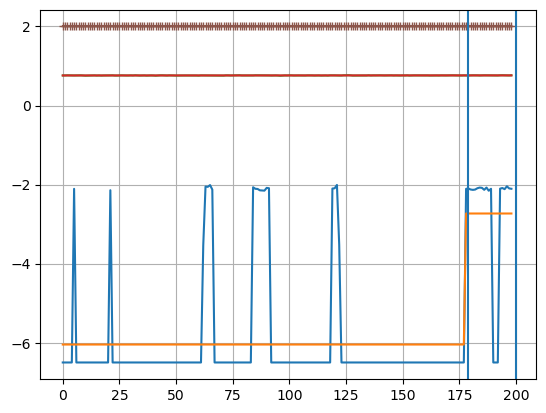

In [31]:
plt.plot(pred_d);plt.plot(np.array(d_seg).repeat(np.diff(np.concatenate(([0],cps)))));
plt.plot(pred_a);plt.plot(np.array(a_seg).repeat(np.diff(np.concatenate(([0],cps)))));
plt.plot(np.argmax(pred_s,axis=-1),'--');plt.plot(np.array(s_seg).repeat(np.diff(np.concatenate(([0],cps)))), '-+');plt.grid();
for cp in cps+1: plt.axvline(cp);

In [32]:
keep_cps = np.logical_or(np.abs(np.diff(a_seg))>0.1 ,np.abs(np.diff(d_seg))>0.1)

In [33]:
keep_cps, len(a_seg), len(cps)

(array([ True]), 2, 2)

In [34]:
a_seg

array([0.76087135, 0.7626073 ], dtype=float32)

In [35]:
L(s_seg[1:])[keep_cps]

(#1) [array([2])]

In [36]:
L(a_seg[1:])[keep_cps]

(#1) [array([0.7626073], dtype=float32)]

In [37]:
a_seg = a_seg[0:1]+ L(a_seg[1:])[keep_cps]; a_seg

array([[1.5234786]], dtype=float32)

In [38]:
cps

array([178, 199])

In [39]:
keep_cps=[False, False, True, False]

In [42]:
#cps = np.concatenate((cps[1:-1][keep_cps],cps[-1:])) if np.any(keep_cps) else cps[-1:]

In [43]:
pred_s.shape, s_seg

((200, 4), array([2, 2]))

In [44]:
cps, cps[1:]+1, len(a_seg), len(d_seg)

(array([178, 199]), array([200]), 1, 2)

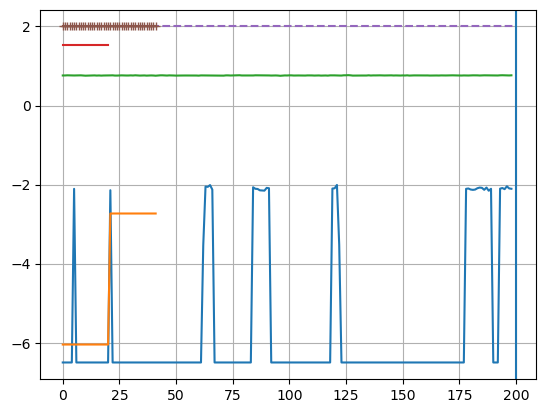

In [45]:
plt.plot(pred_d);plt.plot(np.array(d_seg).repeat(cps[1:] - cps[:-1]));
plt.plot(pred_a);plt.plot(np.array(a_seg).repeat(cps[1:] - cps[:-1]));
plt.plot(np.argmax(pred_s,axis=-1),'--');plt.plot(np.array(s_seg).repeat(cps[1:] - cps[:-1]), '-+');plt.grid();
for cp in cps[1:]+1: plt.axvline(cp);

### Predict

In [48]:
# Define the number of experiments and number of FOVS
N_EXP  = 12  # 13 
N_FOVS = 30

# We only do track 2
track = 2

# The results go in the same folders generated above
#path_results = 'res/'
path_track = path_results + f'track_{track}/'

for exp in trange(N_EXP):
    path_exp = path_track + f'exp_{exp}/'
    # the folder has to exist for writing the results file therein
    if not os.path.exists(path_exp):    os.makedirs(path_exp)
    for fov in range(N_FOVS):
        # We read the corresponding csv file from the public data and extract the indices of the trajectories:
        df = pd.read_csv(public_data_path/f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv', engine='pyarrow')

        # DATA PREPARATION----------------------------------------------------
        # df to trajs in numpy array
        traj_idx, lengths = np.unique(df['traj_idx'].values, return_counts=True)
        trajs = np.array_split(df[['x','y']].values, np.cumsum(lengths)[:-1]) # assumes data is ordered by trajs_idx, alternative using mask
        trajs_t = L([torch.tensor(traj, dtype=torch.float).unsqueeze(0).to(default_device()) for traj in trajs])
        trajs_polar = L([torch.tensor(cartesian_to_relative_polar(traj[None]), dtype=torch.float).to(default_device()) for traj in trajs])
        # disp = [traj[1:] - traj[:-1] for traj in trajs]
        # std  = [dis.std(0,keepdims=True) for dis in disp]
        # trajs_norm = L([torch.cat((torch.tensor(np.zeros_like(sd), dtype=torch.float),
        #                           torch.tensor(dis/sd, dtype=torch.float
        #                                       ).cumsum(0)), dim=0).unsqueeze(0).to(default_device())
        #                 for dis, sd in zip(disp, std)])
       
        # create batches
        bs = 10
        trajs_batches = create_batches(trajs_t, lengths, bs=bs)
        # trajs_norm_b  = create_batches(trajs_norm, lengths, bs=bs)
        trajs_polars = create_batches(trajs_polar, lengths, bs=bs)
        
                
        # apply STEP in batches to predict alpha, log10D, state, CP?-------------
        # preds_a_b = [pred(learn_alpha.model, t) for t in trajs_norm_b ] # tqdm(trajs_norm_b)]
        preds_a_b = [pred(learn_alpha.model, t)  for t in trajs_polars]
        # preds_d_b = [pred(learn_log_d.model, t) for t in trajs_batches]
        preds_d_b = [pred(learn_log_d.model, torch.log10(torch.maximum(t,torch.tensor(1e-10)))) for t in trajs_polars]
        preds_s_b = [pred(learn_state.model, t) for t in trajs_batches]
        
        preds_a = flat_batches(preds_a_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze()) # N, T-1 # T
        preds_d = flat_batches(preds_d_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze()) # N, T-1 from STEPlog10D
        preds_s = flat_batches(preds_s_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze()) # N, T
        
        submission_file = path_exp + f'fov_{fov}.txt'
        with open(submission_file, 'w') as f:
            # Loop over each index
            for idx in traj_idx:
                idx = int(idx)
                # apply ruptures ----------------------------------------------
                # loop over predictions with find_segment
                seg_d, seg_a, seg_s, cps = find_segments(preds_d[idx], # log10D T-1
                                                         np.clip(preds_a[idx],0.,1.999), #[1:], T-1
                                                         np.argmax(preds_s[idx][1:], axis=-1), # T-1
                                                         min_size=4, pen=5, kernel="rbf") # pen=5
                seg_d, seg_a, seg_s = list(map(np.array, [seg_d, seg_a, seg_s]))
                # Check cps[-1] is total_length, yes
                #states = np.random.randint(0, high=4, size=len(seg_a))
                # avoid too close values in segments
                keep_cps = np.logical_or(np.abs(np.diff(seg_a))>0.1 ,np.abs(np.diff(seg_d))>0.1)
                seg_a = np.concatenate((seg_a[0:1], seg_a[1:][keep_cps]))
                seg_d = np.concatenate((seg_d[0:1], seg_d[1:][keep_cps]))
                seg_s = np.concatenate((seg_s[0:1], seg_s[1:][keep_cps]))
                cps   = np.concatenate((cps[1:-1][keep_cps],cps[-1:])) if np.any(keep_cps) else cps[-1:]
                # to be consistent with the prediction alpha>=1.9 is directed motion
                if np.any(a_seg>=1.9):    s_seg[np.argwhere(a_seg>=1.9)]=3

                prediction_traj = [idx] + [b for a in list(zip( 10**np.array(seg_d), seg_a, seg_s, cps+1)) for b in a]
                formatted_numbers = ','.join(map(str, prediction_traj))
                f.write(formatted_numbers + '\n')

    print('Saved at', path_exp)

  0%|          | 0/12 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/res/track_2/exp_0/
Saved at ../../data/submit/20240714/res/track_2/exp_1/
Saved at ../../data/submit/20240714/res/track_2/exp_2/
Saved at ../../data/submit/20240714/res/track_2/exp_3/
Saved at ../../data/submit/20240714/res/track_2/exp_4/
Saved at ../../data/submit/20240714/res/track_2/exp_5/
Saved at ../../data/submit/20240714/res/track_2/exp_6/
Saved at ../../data/submit/20240714/res/track_2/exp_7/
Saved at ../../data/submit/20240714/res/track_2/exp_8/
Saved at ../../data/submit/20240714/res/track_2/exp_9/
Saved at ../../data/submit/20240714/res/track_2/exp_10/
Saved at ../../data/submit/20240714/res/track_2/exp_11/


### Predict from video detections

In [49]:
def take_VIP_coords_from_mask(mask):
    idx_unordered = np.argwhere(mask != 255)[:,[2,1,0]]
    # restore order of appearence
    # Create a dictionary to store the particle IDs
    particle_ids = {}
    id_counter = 0
    # Iterate over the array to assign particle IDs
    for c in idx_unordered[:,[1,2]]:
        if tuple(c) not in particle_ids:
            particle_ids[tuple(c)]       = id_counter
            particle_ids[tuple(c+[1,0])] = id_counter+1
            particle_ids[tuple(c+[0,1])] = id_counter+2
            particle_ids[tuple(c+[1,1])] = id_counter+3
            id_counter += 4
    return np.array([idx_unordered[particle_ids[tuple(c)]] for c in idx_unordered[:,[1,2]]])

In [50]:
def read_video_from_path(path):
    try:
        reader = imageio.get_reader(path)
    except Exception as e:
        print("Error opening video file: ", e)
        return None
    frames = [np.array(im) for im in reader]
    vip_mask = frames[0]
    vip_idx, s = np.unique(vip_mask, return_index=True)
    # np.unique sorts by value, but we want to preserve appearance order
    vip_idx, s = vip_idx[:-1], s[:-1]  # discard the last, 255
    vip_idx = vip_idx[np.argsort(s)]
    vip_start = take_VIP_coords_from_mask(vip_mask)
    return np.stack(frames[1:]), vip_start, vip_idx

#### video pipeline verification

In [ ]:
trajs_path = Path(path_intermediate_results + f'track_{track}/' + f'exp_{0}/')/f'trajs_fov_{0}.npy'
trajs_ = np.load(trajs_path, allow_pickle=True)
        
# DATA PREPARATION----------------------------------------------------
# select VIP trajectories
video_path = public_data_path/f'track_{track}/exp_{0}/videos_fov_{0}.tiff'
video, vip_start, vip_idx = read_video_from_path(video_path)

In [ ]:
vip_idx

array([33, 23, 26, 32, 34, 29, 30, 27, 28,  0], dtype=uint8)

In [ ]:
vip_start

array([[  0,  62,  11],
       [  0,  63,  11],
       [  0,  62,  12],
       [  0,  63,  12],
       [  0,  49,  18],
       [  0,  50,  18],
       [  0,  49,  19],
       [  0,  50,  19],
       [  0,  77,  20],
       [  0,  78,  20],
       [  0,  77,  21],
       [  0,  78,  21],
       [  0,  65,  33],
       [  0,  66,  33],
       [  0,  65,  34],
       [  0,  66,  34],
       [  0,  11,  35],
       [  0,  12,  35],
       [  0,  11,  36],
       [  0,  12,  36],
       [  0,  83,  53],
       [  0,  84,  53],
       [  0,  83,  54],
       [  0,  84,  54],
       [  0,  90,  66],
       [  0,  91,  66],
       [  0,  90,  67],
       [  0,  91,  67],
       [  0, 122,  82],
       [  0, 123,  82],
       [  0, 122,  83],
       [  0, 123,  83],
       [  0,  93, 108],
       [  0,  94, 108],
       [  0,  93, 109],
       [  0,  94, 109],
       [  0,   5, 113],
       [  0,   6, 113],
       [  0,   5, 114],
       [  0,   6, 114]])

In [ ]:
det_start = np.stack([t[0,[2,1]] for t in trajs_ if (t.shape[0]>=20) & (t[0,0]==0.)])
det_trajs = [t[:,[2,1]] for t in trajs_ if (t.shape[0]>=20) & (t[0,0]==0.)]

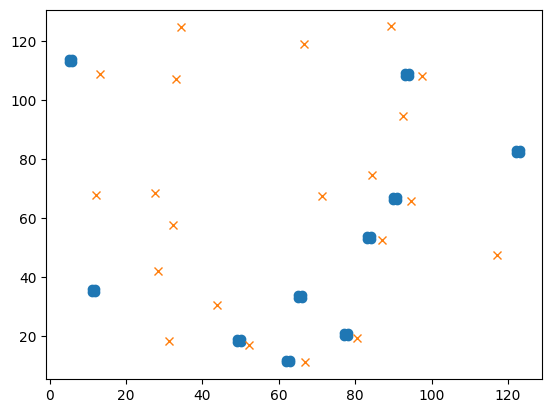

In [ ]:
plt.plot(*vip_start[:,1:].T, 'o');
plt.plot(*det_start.T,'x');

In [ ]:
vip_traj_idx = []
for vip, vip_id in zip(vip_start[::4], vip_idx):
    # get distance with all detections
    d = np.linalg.norm(vip[1:] -det_start, axis=-1)
    # take the closest if close enough
    c = np.argmin(d) if d.min()<7 else None # pixels
    if c is not None:
        vip_traj_idx.append([c,vip_id])

In [ ]:
vip_traj_idx = np.stack(vip_traj_idx)
vip_traj_idx

array([[ 0, 33],
       [ 1, 23],
       [ 3, 26],
       [ 7, 29],
       [ 9, 30],
       [17, 28]])

In [ ]:
vip_traj_idx[:,1]

array([33, 23, 26, 29, 30, 28])

In [ ]:
vip_start[::4][2]

array([ 0, 77, 20])

In [ ]:
det_trajs[vip_traj_idx[:,0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
trajs_ = [det_trajs[v[0]] for v in vip_traj_idx]

In [ ]:
trajs_

[array([[66.7399   , 11.032705 ],
        [67.2082   , 11.225632 ],
        [67.06314  , 11.082827 ],
        [66.80839  , 10.893167 ],
        [66.63387  , 10.641431 ],
        [66.45863  , 10.465021 ],
        [66.76177  , 10.988464 ],
        [66.91787  , 11.078679 ],
        [66.898964 , 11.478134 ],
        [67.198326 , 10.925583 ],
        [67.07301  , 11.174047 ],
        [66.474915 , 13.035826 ],
        [66.74199  , 11.765136 ],
        [66.39085  , 13.1139345],
        [66.48975  , 12.519442 ],
        [66.645615 , 12.935587 ],
        [66.85     , 13.118841 ],
        [66.98143  , 13.131035 ],
        [67.0367   , 13.220375 ],
        [66.42105  , 13.635896 ],
        [66.673325 , 13.401667 ],
        [66.3992   , 13.589163 ],
        [66.31595  , 13.192719 ],
        [66.85775  , 14.092625 ],
        [66.57943  , 13.792026 ],
        [68.630615 , 14.531639 ],
        [68.80243  , 15.28097  ]], dtype=float32),
 array([[52.180626, 16.968437],
        [52.43643 , 16.542038],
 

#### Create video predictions

In [56]:
# Define the number of experiments and number of FOVS
N_EXP  = 12  # 13 
N_FOVS = 30

# We only do track 2
track = 1

# The results go in the same folders generated above
#path_results = 'res/'
path_track = path_results + f'track_{track}/'

path_intermediate_results = "../../data/submit/20240714/proc/" # path_submit + 'proc/'

In [57]:
import imageio

In [58]:
for exp in trange(N_EXP):
    path_exp = path_track + f'exp_{exp}/'
    # the folder has to exist for writing the results file therein
    if not os.path.exists(path_exp):    os.makedirs(path_exp)
    for fov in range(N_FOVS):
        # We read the corresponding npy file from the public data
        trajs_path = Path(path_intermediate_results + f'track_{track}/' + f'exp_{exp}/')/f'trajs_fov_{fov}.npy'
        trajs_ = np.load(trajs_path, allow_pickle=True)
        
        # DATA PREPARATION----------------------------------------------------
        # select VIP trajectories
        video_path = public_data_path/f'track_{track}/exp_{exp}/videos_fov_{fov}.tiff'
        video, vip_start, vip_idx = read_video_from_path(video_path)
        try:
            det_start = np.stack([t[0,[2,1]] for t in trajs_ if (t.shape[0]>=20) & (t[0,0]==0.)])
        except:
            continue
        det_trajs = [t[:,[2,1]] for t in trajs_ if (t.shape[0]>=20) & (t[0,0]==0.)]
        vip_traj_idx = []
        for vip, vip_id in zip(vip_start[::4], vip_idx):
            # get distance with all detections
            d = np.linalg.norm(vip[1:] -det_start, axis=-1)
            # take the closest if close enough
            c = np.argmin(d) if d.min()<10 else None # pixels
            if c is not None:
                vip_traj_idx.append([c,vip_id])
        # print(d)
        # print(det_start)
        try:
            vip_traj_idx = np.stack(vip_traj_idx)
        except:
            continue
        trajs = [det_trajs[v[0]] for v in vip_traj_idx]
        # preprocess
        # traj_idx, lengths = np.unique(df['traj_idx'].values, return_counts=True)
        # trajs = np.array_split(df[['x','y']].values, np.cumsum(lengths)[:-1]) # assumes data is ordered by trajs_idx, alternative using mask
        trajs_t = L([torch.tensor(traj, dtype=torch.float).unsqueeze(0).to(default_device()) for traj in trajs])
        trajs_polar = L([torch.tensor(cartesian_to_relative_polar(traj[None]), dtype=torch.float).to(default_device()) for traj in trajs])
        # disp = [traj[1:] - traj[:-1] for traj in trajs]
        # std  = [dis.std(0,keepdims=True) for dis in disp]
        # trajs_norm = L([torch.cat((torch.tensor(np.zeros_like(sd), dtype=torch.float),
        #                           torch.tensor(dis/sd, dtype=torch.float
        #                                       ).cumsum(0)), dim=0).unsqueeze(0).to(default_device())
        #                 for dis, sd in zip(disp, std)])
       
        # create batches
        #bs = 10
        trajs_batches = trajs_t #create_batches(trajs_t, lengths, bs=bs)
        # trajs_norm_b  = create_batches(trajs_norm, lengths, bs=bs)
        trajs_polars = trajs_polar #create_batches(trajs_polar, lengths, bs=bs)
        
                
        # apply STEP in batches to predict alpha, log10D, state, CP?-------------
        # preds_a_b = [pred(learn_alpha.model, t) for t in trajs_norm_b ] # tqdm(trajs_norm_b)]
        preds_a_b = [pred(learn_alpha.model, t).numpy().squeeze()  for t in trajs_polars]
        # preds_d_b = [pred(learn_log_d.model, t) for t in trajs_batches]
        preds_d_b = [pred(learn_log_d.model, torch.log10(torch.maximum(t,torch.tensor(1e-10)))).numpy().squeeze()
                     for t in trajs_polars]
        preds_s_b = [pred(learn_state.model, t).numpy().squeeze() for t in trajs_batches]
        
        # preds_a = flat_batches(preds_a_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze()) # N, T-1 # T
        # preds_d = flat_batches(preds_d_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze()) # N, T-1 from STEPlog10D
        # preds_s = flat_batches(preds_s_b, lengths, bs=bs, f=lambda x: x.numpy().squeeze()) # N, T
        preds_a = preds_a_b
        preds_d = preds_d_b
        preds_s = preds_s_b

        submission_file = path_exp + f'fov_{fov}.txt'
        with open(submission_file, 'w') as f:
            # Loop over each index
            for idx,vip_idx in enumerate(vip_traj_idx[:,1]):
                # apply ruptures ----------------------------------------------
                # loop over predictions with find_segment
                seg_d, seg_a, seg_s, cps = find_segments(preds_d[idx], # log10D T-1
                                                         np.clip(preds_a[idx],0.,1.999), #[1:], T-1
                                                         np.argmax(preds_s[idx][1:], axis=-1), # T-1
                                                         min_size=4, pen=5, kernel="rbf") # pen=5
                seg_d, seg_a, seg_s = list(map(np.array, [seg_d, seg_a, seg_s]))
                # Check cps[-1] is total_length, yes
                #states = np.random.randint(0, high=4, size=len(seg_a))
                # avoid too close values in segments
                keep_cps = np.logical_or(np.abs(np.diff(seg_a))>0.1 ,np.abs(np.diff(seg_d))>0.1)
                seg_a = np.concatenate((seg_a[0:1], seg_a[1:][keep_cps]))
                seg_d = np.concatenate((seg_d[0:1], seg_d[1:][keep_cps]))
                seg_s = np.concatenate((seg_s[0:1], seg_s[1:][keep_cps]))
                cps   = np.concatenate((cps[1:-1][keep_cps],cps[-1:])) if np.any(keep_cps) else cps[-1:]
                # to be consistent with the prediction alpha>=1.9 is directed motion
                if np.any(a_seg>=1.9):    s_seg[np.argwhere(a_seg>=1.9)]=3

                prediction_traj = [int(vip_idx)] + [b for a in list(zip( 10**np.array(seg_d), seg_a, seg_s, cps+1)) for b in a]
                formatted_numbers = ','.join(map(str, prediction_traj))
                f.write(formatted_numbers + '\n')

    print('Saved at', path_exp)

  0%|          | 0/12 [00:00<?, ?it/s]

Saved at ../../data/submit/20240714/res/track_1/exp_0/
Saved at ../../data/submit/20240714/res/track_1/exp_1/
Saved at ../../data/submit/20240714/res/track_1/exp_2/
Saved at ../../data/submit/20240714/res/track_1/exp_3/
Saved at ../../data/submit/20240714/res/track_1/exp_4/
Saved at ../../data/submit/20240714/res/track_1/exp_5/
Saved at ../../data/submit/20240714/res/track_1/exp_6/
Saved at ../../data/submit/20240714/res/track_1/exp_7/
Saved at ../../data/submit/20240714/res/track_1/exp_8/
Saved at ../../data/submit/20240714/res/track_1/exp_9/
Saved at ../../data/submit/20240714/res/track_1/exp_10/
Saved at ../../data/submit/20240714/res/track_1/exp_11/


#### results verification

The first lines of `res/track_2/exp_0/fov_0.txt` should be:

```
0,3.2001715082246784,0.38346389417189797,3,50,3.2468297206646533,0.5197111936582762,0,200
1,8.726506554473954,0.27354203481563577,1,50,8.853376596095856,0.6798794564067695,3,200
2,6.874882763878153,0.21550767711355845,1,50,2.294418344710454,0.8802976031150046,0,200
```

The prediction file should look like:

idx_traj1, K_1, alpha_1, state_1, CP_1, K_2, alpha_2, .... state_N, T

idx_traj2, K_1, alpha_1, state_1, CP_1, K_2, alpha_2, .... state_N, T

idx_traj3, K_1, alpha_1, state_1, CP_1, K_2, alpha_2, .... state_N, T

In [59]:
!ls -alh $path_results/track_2/exp_0

total 128K
drwxrwx---  2 gfernandez Domain Users 4,0K jul 19 16:04 .
drwxrwx--- 14 gfernandez Domain Users 4,0K jul 19 16:07 ..
-rw-rw----  1 gfernandez Domain Users 3,5K jul 19 16:04 fov_0.txt
-rw-rw----  1 gfernandez Domain Users 3,3K jul 19 16:04 fov_10.txt
-rw-rw----  1 gfernandez Domain Users 1,7K jul 19 16:04 fov_11.txt
-rw-rw----  1 gfernandez Domain Users 3,0K jul 19 16:04 fov_12.txt
-rw-rw----  1 gfernandez Domain Users 2,7K jul 19 16:04 fov_13.txt
-rw-rw----  1 gfernandez Domain Users 2,6K jul 19 16:04 fov_14.txt
-rw-rw----  1 gfernandez Domain Users 2,6K jul 19 16:04 fov_15.txt
-rw-rw----  1 gfernandez Domain Users 2,7K jul 19 16:04 fov_16.txt
-rw-rw----  1 gfernandez Domain Users 2,9K jul 19 16:04 fov_17.txt
-rw-rw----  1 gfernandez Domain Users 3,1K jul 19 16:04 fov_18.txt
-rw-rw----  1 gfernandez Domain Users 3,1K jul 19 16:04 fov_19.txt
-rw-rw----  1 gfernandez Domain Users 2,6K jul 19 16:04 fov_1.txt
-rw-rw----  1 gfernandez Domain Users 1,8K jul 19 16:04 fov_20.txt
-rw

In [60]:
df = pd.read_csv(path_results+'track_2/exp_11/fov_29.txt', sep=" ", header=None)
df

,0
0,"0,0.2632892,1.5585798,2,20"
1,"1,12.491592,1.9953772,2,21"
2,"2,0.010162143,1.5287867,2,20"
3,"3,0.043312844,1.84942,2,135"
4,"4,0.0030183855,1.6443729,2,50"
...,...
62,"62,0.023127845,0.92364144,2,25,7.8677954e-07,1.1796708,2,47,0.004750084,1.6461893,2,86"
63,"63,6.578143e-07,1.680895,2,15,0.00081132026,1.3610597,2,68"
64,"64,0.04515829,1.9904648,2,16,1.4622959e-06,0.17085622,0,43,0.11595644,1.0854634,2,55"
65,"65,1.1024075e-05,1.7761134,2,60"


## Ensemble task

In the ensemble task, you must provide the diffusive properties of each state present in the dataset. The submission file should have the following structure:

|model: modelXXX;      |  num_state: YYY     |                      |     |
|:--------------------:|:-------------------:|:--------------------:|:---:|
| $\mu_\alpha^1$;      | $\mu_\alpha^2$;     | $\mu_\alpha^3$;      | ... |
| $\sigma_\alpha^1$;   | $\sigma_\alpha^2$;  | $\sigma_\alpha^3$;   | ... |
| $\mu_K^1$;           | $\mu_K^2$;          | $\mu_K^3$;           | ... |        
| $\sigma_K^1$;        | $\sigma_K^2$;       | $\sigma_K^3$;        | ... |
| $N_1$;               | $N_2$;              | $N_3$;               | ... |

The first row contains the diffusion model prediction for the experiment and the number of diffusive states. Below, every column contains the properties for each of the predicted diffusive states:

- $\mu_\alpha^i$, $\sigma_\alpha^i$: mean and variance of the anomalous diffusion exponent.
- $\mu_K^i$, $\sigma_K^i$: mean and variance of the diffusion coefficient.
- $N_i$: relative weight of the state (e.g. time spent in it).

It is important to use `;` as delimiter of the file.

For the model prediction, the available diffusion models are (and should be written as):

In [61]:
from andi_datasets.datasets_phenom import datasets_phenom
print(datasets_phenom().avail_models_name)

['single_state', 'multi_state', 'immobile_traps', 'dimerization', 'confinement']


Both $\alpha$ and $D$ are bound to some minimal and maximal values:

In [62]:
from andi_datasets.models_phenom import models_phenom
print(f' Min, max D: {models_phenom().bound_D}\n',
      f'Min, max alpha: {models_phenom().bound_alpha}')

 Min, max D: [1e-12, 1000000.0]
 Min, max alpha: [0, 1.999]


For instance the file `res/track_1/exp_0/ensemble_labels.txt` should look something like:

```
model: confinement; num_state: 2 
5.928446182250183272e-01;8.442657485810173279e-01
8.579456176227567843e-01;8.472517387841254077e-01
6.235636967859723434e-01;3.843817072926998257e-01
2.975346065444722798e-01;5.671297731744318060e-02
3.633859973276627464e-01;6.366140026723372536e-01
```


### Load segments

In [63]:
#| export

from pathlib import Path

import re, shutil, numpy as np, pandas as pd
from tqdm.auto import tqdm, trange
from fastai.vision.all import *
from torch.utils.data import Dataset#, DataLoader

In [64]:
# load segments
# from experiment FOVs' txt files
#| export

def read_segments(data_path, track: str="2", exp: str='0'):
    """Extract segments info from the fov files in the given path."""
    stats = {"ks": [], "alphas": [], "states": [], "cps": [], "res": [],}
    # for exp_path in tqdm((data_path/f"track_{track}").iterdir(),):# total=num_FOVs):
    exp_path = data_path/f"track_{track}/exp_{exp}"
    # if not exp_path.is_dir():    continue

    traj_label_files = sorted([f for f in exp_path.iterdir() if re.search(r"fov_\d*.txt", f.name)])
    
    for file in traj_label_files:
        with open(file, "r") as f:
            traj_info = f.readlines()

        fov_ks, fov_alphas, fov_states, fov_cps, fov_res_time = [], [], [], [], []
        for info in traj_info:
            ks, alphas, states, cps = _parse_trajectory_info(info)
            fov_ks.append(ks)
            fov_alphas.append(alphas)
            fov_states.append(states)
            fov_cps.append(cps)
            if len(cps)>1:
                fov_res_time.append(cps[0:1]+[cp-cp_ for cp, cp_ in zip(cps[1:],cps[:-1])])
            elif len(cps)==1:
                fov_res_time.append(cps)
            else:
                raise Error
        stats["ks"].append(fov_ks)
        stats["alphas"].append(fov_alphas)
        stats["states"].append(fov_states)
        stats["cps"].append(fov_cps)
        stats["res"].append(fov_res_time)
        
    return stats

def _parse_trajectory_info(info):
    """Extract the trajectory information from the labels. 
    The file format is:
    traj_idx,K_0,alpha_0,state_0,cp_0,...,state_n,traj_len"""
    ks, alphas, states, cps = [], [], [], []
    split_info = re.findall(r"\d*,(.*)\n$", info)[0].split(",")
    ks.extend(    [float(f)  for f in split_info[::4]])
    alphas.extend([float(f)  for f in split_info[1::4]])
    states.extend([int(i[0]) for i in split_info[2::4]])
    cps.extend(   [int(i)    for i in split_info[3::4]])
    return ks, alphas, states, cps

In [70]:
path_submit = Path('../../data/submit/20240714/')  # 20240710/')  # 20240628/')
path_results = path_submit/'res/'

In [71]:
!ls {path_results/'track_2/exp_0'}

fov_0.txt   fov_14.txt	fov_19.txt  fov_23.txt	fov_28.txt  fov_5.txt
fov_10.txt  fov_15.txt	fov_1.txt   fov_24.txt	fov_29.txt  fov_6.txt
fov_11.txt  fov_16.txt	fov_20.txt  fov_25.txt	fov_2.txt   fov_7.txt
fov_12.txt  fov_17.txt	fov_21.txt  fov_26.txt	fov_3.txt   fov_8.txt
fov_13.txt  fov_18.txt	fov_22.txt  fov_27.txt	fov_4.txt   fov_9.txt


In [72]:
df = pd.read_csv(path_results/'track_2/exp_0/fov_0.txt', sep=" ", header=None); df

,0
0,"0,2.0281577e-06,1.1719921,2,200"
1,"1,8.998176e-07,0.76087135,2,179,0.0018566495,0.7626073,2,200"
2,"2,0.016038626,1.1027405,2,10,3.0453977e-05,1.1012818,2,95,0.015767954,1.1016259,2,106,1.3436846e-06,1.1012464,2,196,0.016507471,1.1036786,2,200"
3,"3,9.083623e-07,0.96437865,2,200"
4,"4,3.603164e-06,1.0386454,2,67,0.019148925,1.0353097,2,78,3.4949412e-06,1.0398713,2,200"
5,"5,2.0140798e-05,1.0049045,2,64,0.0014237236,1.0418545,2,83,2.2456086e-06,1.0245553,2,113,8.7521613e-07,0.9806229,2,200"
6,"6,1.733358e-05,0.88463396,2,93,0.008176369,0.88398993,2,103,1.9134745e-06,0.8839545,2,200"
7,"7,6.423986e-07,0.86115056,2,164,9.799809e-05,0.8559706,2,200"
8,"8,6.7689393e-06,1.0156045,2,150"
9,"9,0.030595677,0.9803129,2,13,3.1637327e-07,0.9785837,2,28,0.0019505639,0.9789769,2,65,3.1622778e-07,0.9783879,2,95,2.6079162e-05,0.978598,2,200"


In [73]:
# set manually after analysis of k-means and visual inspection
num_states_exp = [2,2,5,4,5,2,2,6,5,3, 4, 6] #[2,2,2,2,4,2,2,3,2,3,4,3,3]
# some big values are hacks for kmeans to cluster properly

In [74]:
def flattten_list_to_array(l): return np.concatenate([subitem for item in l for subitem in item])

In [79]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.colors as clr

### pipeline verification

In [ ]:
# dry run, not saved
for exp, n_states in enumerate(num_states_exp):
    seg = read_segments(path_results, exp=str(exp))
    seg_flat = list(map(flattten_list_to_array, [seg[label] for label in ["alphas", "ks", "states", "cps", "res"]]))
    seg_flat_alphas, seg_flat_ks, seg_flat_states, seg_flat_cps, seg_flat_res = seg_flat 

    scaler = StandardScaler()
    x = np.stack((np.log10(seg_flat_ks), seg_flat_alphas, seg_flat_states), axis=-1)
    x = scaler.fit_transform(x)
    
    # sse = []
    # n_clusters = np.arange(1, 8)
    # for n in tqdm(n_clusters):
    #     kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
    #     kmeans.fit(x)
    #     sse.append(kmeans.inertia_)
    kmeans = KMeans(init="k-means++", n_clusters=n_states,#kl.elbow,
                    n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x)
    seg_labels = kmeans.predict(x)
    data = np.zeros((5,n_states))
    assert n_states==kmeans.n_clusters
    print(f'Exp {exp}')
    for i in range(kmeans.n_clusters):
        if sum(seg_labels==i)/len(seg_labels)<.03: continue
        data[0,i] = np.mean(seg_flat_alphas[seg_labels==i]) # weight with residence_time??
        data[1,i] = np.var (seg_flat_alphas[seg_labels==i])
        data[2,i] = np.mean(seg_flat_ks    [seg_labels==i])
        data[3,i] = np.var (seg_flat_ks    [seg_labels==i])
        data[4,i] = np.sum(seg_flat_res[seg_labels==i])/np.sum(seg_flat_res)
        # print(f'mu D = {np.mean(10**seg_flat_ks[seg_labels==i]):.3g}')
        print(f'mu  a = {data[0,i]:.3g}')
        print(f'var a = {data[1,i]:.3g}')
        print(f'mu  D = {data[2,i]:.3g}')
        print(f'var D = {data[3,i]:.3g}')
        print(f'res T = {data[4,i]:.1%}')
        print(f'label = {sum(seg_labels==i)/len(seg_labels):.1%}')
        print()
    print('-'*8)

Exp 0
mu  a = 1.02
var a = 0.00722
mu  D = 0.948
var D = 26.9
res T = 48.4%
label = 38.7%

mu  a = 0.986
var a = 0.0109
mu  D = 3.39e-07
var D = 4.8e-11
res T = 51.6%
label = 61.3%

--------
Exp 1
mu  a = 1
var a = 0.00889
mu  D = 1.57
var D = 91.9
res T = 45.7%
label = 38.9%

mu  a = 1
var a = 0.0105
mu  D = 4.01e-08
var D = 4.33e-14
res T = 54.3%
label = 61.1%

--------
Exp 2
mu  a = 1.07
var a = 0.0186
mu  D = 2.41e-06
var D = 8.36e-11
res T = 14.3%
label = 23.5%

mu  a = 0.315
var a = 0.0219
mu  D = 5.47e-08
var D = 1.93e-13
res T = 6.8%
label = 8.2%

mu  a = 1.07
var a = 0.0174
mu  D = 19.6
var D = 3.91e+03
res T = 70.4%
label = 57.5%

mu  a = 0.367
var a = 0.035
mu  D = 20.6
var D = 1.07e+04
res T = 6.0%
label = 8.3%

--------
Exp 3
mu  a = 0.578
var a = 0.142
mu  D = 1.02e-07
var D = 4.24e-13
res T = 23.7%
label = 29.9%

mu  a = 1.07
var a = 0.0201
mu  D = 25.8
var D = 1.32e+04
res T = 37.8%
label = 36.8%

mu  a = 0.29
var a = 0.00753
mu  D = 11
var D = 7.63e+03
res T = 14.1%
la

#### Examples

In [ ]:
exp = 11

In [ ]:
seg = read_segments(path_results, exp=str(exp))

In [ ]:
seg_flat = list(map(flattten_list_to_array, [seg[label] for label in ["alphas", "ks", "states", "cps", "res"]]))
seg_flat_alphas, seg_flat_ks, seg_flat_states, seg_flat_cps, seg_flat_res = seg_flat 

In [ ]:
# from functools import partial
# plt.hist= partial(plt.hist, histtype='step')

In [ ]:
#plt.hist(seg_flat_alphas,100, log=1);

In [ ]:
# plt.hist(seg_flat_ks,bins=np.geomspace(1e-4,10,200));plt.xscale('log');plt.ylim(0,100);

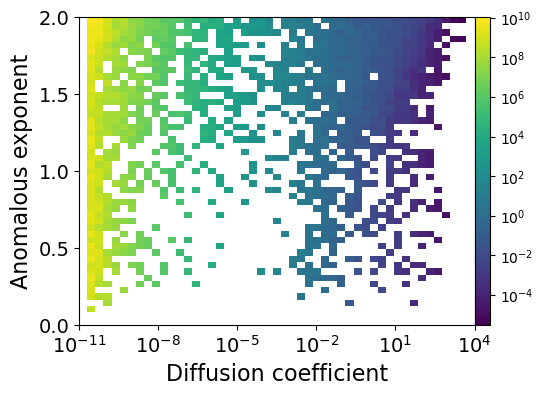

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_flat_ks, seg_flat_alphas, 
           bins=[#np.geomspace(1e-7,1e3,50),
                 np.geomspace(1e-11,1e4,50),
                 np.linspace(0,2,50)], density=True,
           # cmap=cmap
           norm=matplotlib.colors.LogNorm(),
          );

plt.colorbar(pad=0);
plt.xlabel('Diffusion coefficient', fontsize=16); plt.xscale('log');
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

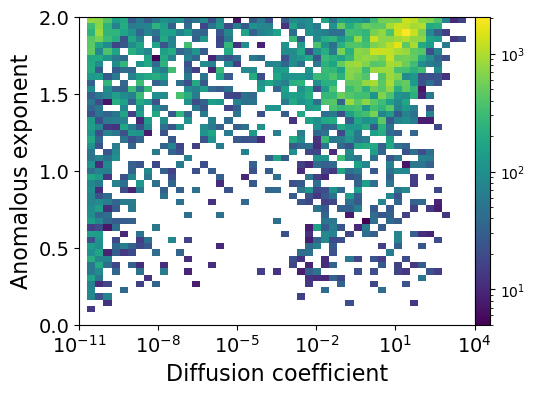

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist2d(seg_flat_ks, seg_flat_alphas, 
           bins=[#np.geomspace(1e-7,1e3,50),
                 np.geomspace(1e-11, 1e4,50),
                 np.linspace(0,2,50)],
           # cmap=cmap
           weights = seg_flat_res,
           norm=matplotlib.colors.LogNorm(),
          );
plt.colorbar(pad=0);

plt.xlabel('Diffusion coefficient', fontsize=16); plt.xscale('log');
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

#### Clustering segments

In [78]:
scaler = StandardScaler()
x = np.stack((np.log10(seg_flat_ks), seg_flat_alphas, seg_flat_states), axis=-1)
x = scaler.fit_transform(x)

sse = []
n_clusters = np.arange(1, 8)
for n in tqdm(n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

NameError: name 'seg_flat_ks' is not defined

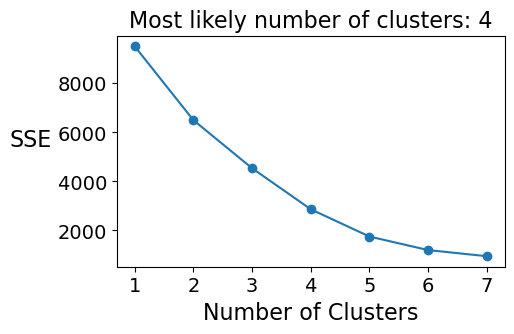

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(n_clusters, sse, 'o-')
plt.xticks(n_clusters)
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("SSE", rotation=0,ha='right', fontsize=16)
plt.tick_params(labelsize=14)
kl = KneeLocator(n_clusters, sse, curve="convex", direction="decreasing")
plt.title(f"Most likely number of clusters: {kl.elbow}", fontsize=16);

In [ ]:
num_states_exp[exp]

6

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=num_states_exp[exp],#kl.elbow,
                n_init=10, max_iter=300, random_state=42)
kmeans.fit(x)
seg_labels = kmeans.predict(x)

In [ ]:
for i in range(kmeans.n_clusters):
    print(f'perc = {sum(seg_labels==i)/len(seg_labels):.1%}')
    print(f'perc T = {sum(seg_flat_res[seg_labels==i])/sum(seg_flat_res):.1%}')

    # print(f'mu D = {np.mean(10**seg_flat_ks[seg_labels==i]):.3g}')
    print(f'mu  D = {np.mean(seg_flat_ks    [seg_labels==i]):.3g}')
    print(f'std D = {np.std(seg_flat_ks    [seg_labels==i]):.3g}')
    print(f'mu a = {np.mean(seg_flat_alphas[seg_labels==i]):.3g}')
    print(f'std a = {np.std(seg_flat_alphas[seg_labels==i]):.3g}')
    print()

perc = 11.2%
perc T = 7.7%
mu  D = 20.1
std D = 82.3
mu a = 0.833
std a = 0.307

perc = 51.4%
perc T = 65.8%
mu  D = 43.4
std D = 199
mu a = 1.75
std a = 0.186

perc = 23.2%
perc T = 19.3%
mu  D = 1.42e-06
std D = 6.76e-06
mu a = 1.74
std a = 0.224

perc = 0.9%
perc T = 0.4%
mu  D = 10.3
std D = 44.7
mu a = 0.903
std a = 0.405

perc = 10.9%
perc T = 5.3%
mu  D = 5.93e-08
std D = 3.19e-07
mu a = 0.726
std a = 0.297

perc = 2.4%
perc T = 1.5%
mu  D = 55.9
std D = 116
mu a = 1.83
std a = 0.333



In [ ]:
color_order = ['blue', 'orange', 'yellow', 'purple', 'green']; colors = [f'C{i}' for i in range(5)]

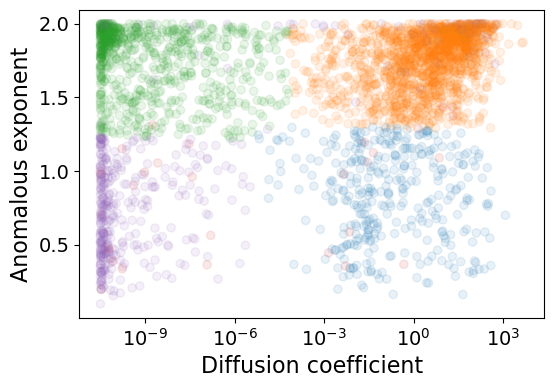

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(seg_flat_ks, seg_flat_alphas, c=seg_labels, alpha=0.1, 
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16); plt.xscale('log');
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

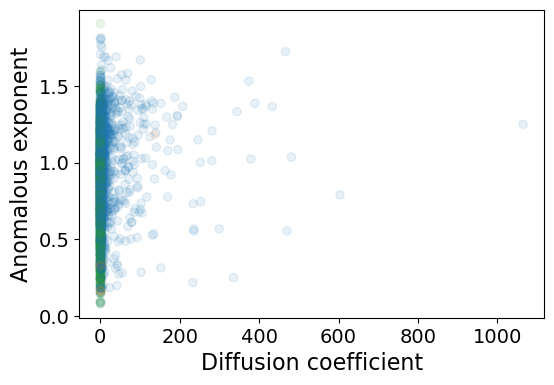

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(#np.log10(seg_flat_ks),
            seg_flat_ks,
            seg_flat_alphas, c=seg_labels, alpha=0.1, 
            cmap=clr.ListedColormap(colors), norm=clr.BoundaryNorm(np.arange(5), 4))

plt.xlabel('Diffusion coefficient', fontsize=16);
plt.ylabel('Anomalous exponent', fontsize=16)
plt.tick_params(labelsize=14)

### Predict ensembles

In [82]:
for track in [2]:    
    # Create the folder of the track if it does not exists
    path_track = path_results / f'track_{track}/'
    if not os.path.exists(path_track):    os.makedirs(path_track)

    for exp, n_states in enumerate(num_states_exp):
        # create data states from segment predictions
        print(f'Exp {exp}')
        seg = read_segments(path_results, exp=str(exp))
        seg_flat = list(map(flattten_list_to_array, [seg[label] for label in ["alphas", "ks", "states", "cps", "res"]]))
        seg_flat_alphas, seg_flat_ks, seg_flat_states, seg_flat_cps, seg_flat_res = seg_flat 
    
        scaler = StandardScaler()
        x = np.stack((np.log10(seg_flat_ks), seg_flat_alphas, seg_flat_states), axis=-1)
        x = scaler.fit_transform(x)
        
        # sse = []
        # n_clusters = np.arange(1, 8)
        # for n in tqdm(n_clusters):
        #     kmeans = KMeans(init="k-means++", n_clusters=n, n_init=10, max_iter=300, random_state=42)
        #     kmeans.fit(x)
        #     sse.append(kmeans.inertia_)
        kmeans = KMeans(init="k-means++", n_clusters=n_states,#kl.elbow,
                        n_init=10, max_iter=300, random_state=42)
        kmeans.fit(x)
        seg_labels = kmeans.predict(x)
        data = np.zeros((5,n_states))
        assert n_states==kmeans.n_clusters
        n_states_ = 0
        for i in range(kmeans.n_clusters):
            if sum(seg_labels==i)/len(seg_labels)<.03: continue
            n_states_+=1
            data[0,i] = np.mean(seg_flat_alphas[seg_labels==i]) # weight with residence_time??
            data[1,i] = np.var (seg_flat_alphas[seg_labels==i])
            data[2,i] = np.mean(seg_flat_ks    [seg_labels==i])
            data[3,i] = np.var (seg_flat_ks    [seg_labels==i])
            data[4,i] = np.sum(seg_flat_res[seg_labels==i])/np.sum(seg_flat_res)
            # print(f'mu D = {np.mean(10**seg_flat_ks[seg_labels==i]):.3g}')
            print(f'mu  a = {data[0,i]:.3g}')
            print(f'var a = {data[1,i]:.3g}')
            print(f'mu  D = {data[2,i]:.3g}')
            print(f'var D = {data[3,i]:.3g}')
            print(f'res T = {data[4,i]:.1%}')
            print(f'label = {sum(seg_labels==i)/len(seg_labels):.1%}')
            print()
        print('-'*8)
        # save the data in a file for submission
        # Create the folder of the experiment if it does not exits
        path_exp = path_track/f'exp_{exp}/'
        if not os.path.exists(path_exp):  os.makedirs(path_exp)
        file_name = path_exp / 'ensemble_labels.txt'
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states
            # TODO predict model as states
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {n_states_} \n')
            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')
            print(f'Saved data at {file_name}')

Exp 0
mu  a = 1
var a = 0.00956
mu  D = 5.87e-06
var D = 1.53e-10
res T = 88.1%
label = 64.4%

mu  a = 1.01
var a = 0.00942
mu  D = 0.0102
var D = 0.00013
res T = 11.9%
label = 35.6%

--------
Saved data at ../../data/submit/20240714/res/track_2/exp_0/ensemble_labels.txt
Exp 1
mu  a = 1
var a = 0.00882
mu  D = 0.00914
var D = 8.48e-05
res T = 12.4%
label = 35.4%

mu  a = 0.999
var a = 0.011
mu  D = 5.66e-06
var D = 1.39e-10
res T = 87.6%
label = 64.6%

--------
Saved data at ../../data/submit/20240714/res/track_2/exp_1/ensemble_labels.txt
Exp 2
mu  a = 1.07
var a = 0.018
mu  D = 0.00224
var D = 1.23e-05
res T = 32.5%
label = 19.1%

mu  a = 1.06
var a = 0.018
mu  D = 2.34
var D = 55.5
res T = 22.6%
label = 33.4%

mu  a = 0.313
var a = 0.0237
mu  D = 0.00594
var D = 0.00458
res T = 11.8%
label = 12.1%

mu  a = 1.06
var a = 0.0186
mu  D = 6.79e-06
var D = 8.1e-11
res T = 30.8%
label = 33.4%

--------
Saved data at ../../data/submit/20240714/res/track_2/exp_2/ensemble_labels.txt
Exp 3
mu  

# Zip the submission folder into a file and you are ready to upload to Codalab

In [83]:
# zip folder
import shutil

In [84]:
path_submit

Path('../../data/submit/20240714')

In [85]:
fname_submit = '20240714_STEP_000'  # '20240710_STEP_000' # '20240629_STEP_000'

In [88]:
# assure unique name in the submission folder
i=0
while os.path.exists(path_submit/fname_submit/'.zip'):
    i+=1
    fname_submit = fname_submit[:-3]+ f'{i:03}'
fname_submit, i

('20240714_STEP_000', 0)

In [91]:
shutil.make_archive(path_submit/fname_submit, 'zip', path_results,);

In [94]:
! ls ../../data/submit/20240714/

20240714_STEP_000.zip  proc  res  score


Then, go to the competition webpage in Codalab > Participate > Submit/View Results and use the submission button to submit the compressed file. After some time, you will see the results in the Leaderboard. If something went wrong, you will be able to see it in the same Submission page.

In [ ]:
# TODO automated codalab submission function?? there is not